In [2]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

### Loading the model

In [3]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("s-nlp/russian_toxicity_classifier")
model = AutoModelForSequenceClassification.from_pretrained("s-nlp/russian_toxicity_classifier")

tokenizer_config.json:   0%|          | 0.00/585 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.40M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.04k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/711M [00:00<?, ?B/s]

### I did the installing part partly here, partly with conda. Holy shit it's so slow

In [4]:
import torch
!pip install onnx onnxconverter-common onnxruntime --quiet
import onnx
import os

PREFIX_MODELS = "triton_inference//model_repository"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.5/84.5 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 18.9 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 71.1 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 5.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-bigtable 2.27.0 requires google-api-core[grpc]<3.0.0dev,>=2.16.0, but you have google-api-core 1.34.1 which is incompatible.
pandas-gbq 0.25.0 requires google-api-core<3.0.0dev,>=2.10.2, but you have google-api-core 1.34.1 which is incompatible.
tensorflow 2.17.1 requires protobuf!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0dev,>=3.20.3, but you have protobuf 3.20.2 which is incompatib

### Saving models
- pth (original)
- onnx_fp32
- onnx_fp16
- trt_fp16

Actually you might notice that I'm saving in simply folders, and I had to manually move all thiose files to 1/ folder)

In [44]:
# onnx_fp32
onnx_32_path = "model.onnx"
onnx_16_path = "model.onnx"

onnx_16_model = onnx.load(onnx_16_path)
# onnx_32_model = onnx.load(onnx_32_path)

onnx.checker.check_model(onnx_16_model)

In [ ]:
from onnxconverter_common import float16

onnx_fp16_path = "model_fp16.onnx"

onnx_model_fp16 = float16.convert_float_to_float16(onnx_model)
onnx.save(onnx_model_fp16, onnx_fp16_path)

In [ ]:
import tensorrt as trt
import pycuda.driver as cuda
import pycuda.autoinit
import os

TRT_LOGGER = trt.Logger()

def build_engine(engine_file_path, fp16_mode=True):
    with (trt.Builder(TRT_LOGGER) as builder,
          builder.create_builder_config() as config,
          builder.create_network(1 << (int)(trt.NetworkDefinitionCreationFlag.EXPLICIT_BATCH)) as network,
          trt.OnnxParser(network, TRT_LOGGER) as parser):
        config.max_workspace_size = 1 << 30  # 1G
        if fp16_model:
            config.flags |= 1 << int(trt.BuilderFlag.FP16)

        engine = builder.build_serialized_network(network, config)
        if engine is None:
            print("ERROR: Could not build engine.")
            return None

        with open(engine_file_path, "wb") as f:
            f.write(engine)
        return engine

trt_engine_path = f"{PREFIX_MODELS}/trt_fp16/model.plan"

engine = build_engine(onnx_fp16_path, trt_engine_path)
if engine:
    print(f"TensorRT engine saved to {trt_engine_path}")
else:
    print("TensorRT engine build failed.")

Then I manually made configs and so on...

## Finding optimal threshold

I am working on windows so no gpu in triton sorry
Also as one of the comments claimed - I used a [different dataset](https://huggingface.co/datasets/AlexSham/Toxic_Russian_Comments)

In [5]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score, precision_recall_curve, roc_curve, auc, precision_score
import matplotlib.pyplot as plt
from tqdm import tqdm

splits = {'train': 'train.jsonl', 'test': 'test.jsonl'}
df_train = pd.read_json("hf://datasets/AlexSham/Toxic_Russian_Comments/" + splits["train"], lines=True)
df_test = pd.read_json("hf://datasets/AlexSham/Toxic_Russian_Comments/" + splits["test"], lines=True)

In [3]:
df_train.head()

,text,label
0,"видимо в разных регионах называют по разному ,...",0
1,"понятно что это нарушение правил, писать капсл...",1
2,"какие классные, жизненные стихи....",0
3,а и правда-когда его запретили?...,0
4,в соленой воде вирусы живут .ученые изучали со...,0


In [9]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()
device

device(type='cuda')

In [4]:
model.eval()
all_logits = []
batch_size = 256

for i in tqdm(range(0, len(df_train), batch_size), desc="Processing train..."):
    batch_texts = df_train.loc[i:min(i + batch_size-1, len(df_train)), "text"].to_list()
    inputs = tokenizer(batch_texts, padding='max_length', truncation=True, max_length=128, return_tensors="pt")
    inputs = inputs.to(device)
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits.cpu().numpy()
    all_logits.append(logits)

all_logits = np.concatenate(all_logits, axis=0)
assert len(all_logits) == len(df_train)

Processing train...: 100%|██████████| 873/873 [24:37<00:00,  1.69s/it]


In [ ]:
probabilities = np.exp(all_logits[:, 1]) / np.sum(np.exp(all_logits), axis=1)

In [27]:
from sklearn.metrics import precision_score

def find_optimal_threshold(probabilities, labels, target_precision=0.9):
    sorted_indices = np.argsort(-probabilities)
    sorted_probabilities = probabilities[sorted_indices]
    sorted_labels = labels[sorted_indices]

    tp = 0
    fp = 0
    n_labels = len(labels)

    for i in range(n_labels):
        if sorted_labels[i] == 1:
            tp += 1
        else:
            fp += 1

        precision = tp / (tp + fp)

        if precision >= target_precision:
            optimal_threshold = sorted_probabilities[i]
            return optimal_threshold

    return 0.5

optimal_threshold = find_optimal_threshold(probabilities, df_train["label"], target_precision=0.9)
print(f"Optimal threshold with 0.9 precision: {optimal_threshold}")

Optimal threshold with 0.9 precision: 0.5


ROC AUC: 0.9982130399641956


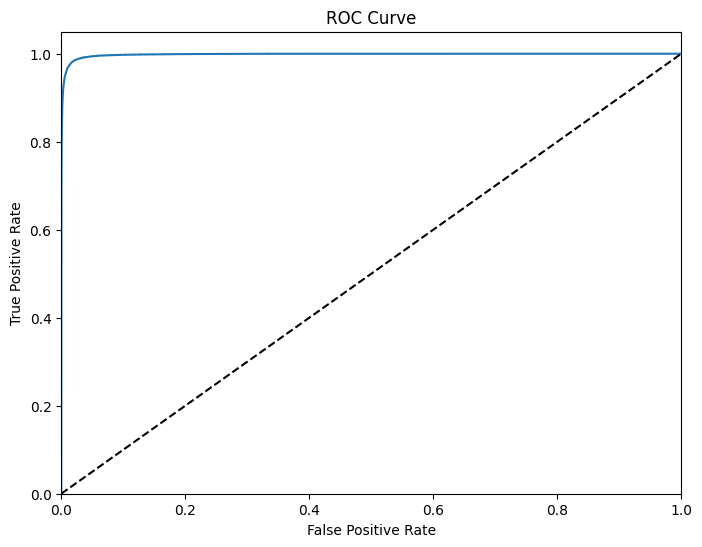

In [28]:
roc_auc = roc_auc_score(df_train["label"], probabilities)
print(f"ROC AUC: {roc_auc}")

fpr, tpr, thresholds = roc_curve(df_train["label"], probabilities)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.show()

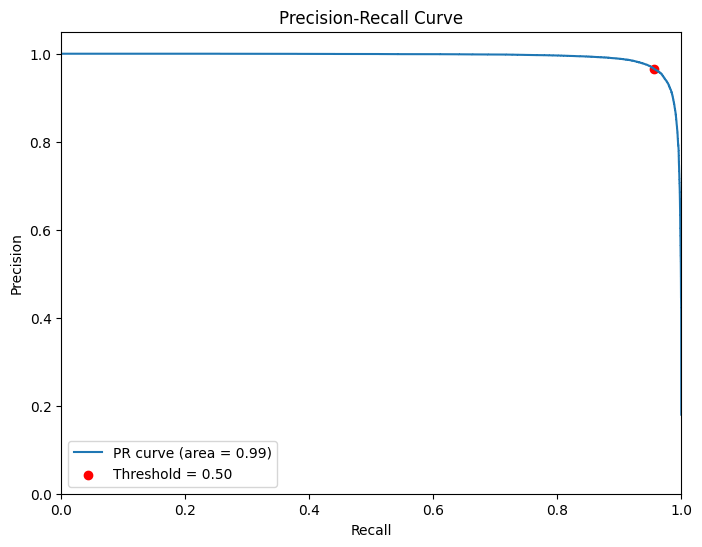

In [30]:
closest_idx = np.argmin(np.abs(thresholds - optimal_threshold))
precision, recall, thresholds = precision_recall_curve(df_train["label"], probabilities)
pr_auc = auc(recall, precision)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'PR curve (area = {pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

recall_threshold_index = np.argmin(np.abs(thresholds - optimal_threshold))

plt.scatter(recall[recall_threshold_index], precision[recall_threshold_index], color='red', label=f'Threshold = {optimal_threshold:.2f}')
plt.legend()
plt.show()

### Inferencing pt on test

In [14]:
from sklearn.metrics import accuracy_score, f1_score, precision_score
from sklearn.metrics import roc_auc_score, precision_recall_curve, roc_curve, auc, precision_score

def model_pt_predict(model):
    model.eval()
    def inference(batch_texts):
        inputs = tokenizer(batch_texts, padding='max_length', truncation=True, max_length=128, return_tensors="pt")
        inputs = inputs.to(device)
        with torch.no_grad():
            outputs = model(**inputs)
            logits = outputs.logits.cpu().numpy()
        return logits
    return inference

def run_model_on_data(model_predict, data, threshold=0.5):
    all_logits = []
    batch_size = 256

    for i in tqdm(range(0, len(data), batch_size), desc="Processing data..."):
        batch_texts = data.loc[i:min(i + batch_size-1, len(data)), "text"].to_list()
        logits = model_predict(batch_texts)
        all_logits.append(logits)

    all_logits = np.concatenate(all_logits, axis=0)
    assert len(all_logits) == len(data)
    probabilities = np.exp(all_logits[:, 1]) / np.sum(np.exp(all_logits), axis=1)
    predictions = probabilities > threshold

    accuracy = accuracy_score(data["label"], predictions)
    f1 = f1_score(data["label"], predictions)
    tp = np.sum((predictions == 1) & (data["label"] == 1))
    fp = np.sum((predictions == 1) & (data["label"] == 0))
    tn = np.sum((predictions == 0) & (data["label"] == 0))
    fn = np.sum((predictions == 0) & (data["label"] == 1))

    print(f"Accuracy: {accuracy:.2f}")
    print(f"F1 Score: {f1:.2f}")
    print(f"True Positives: {tp}")
    print(f"False Positives: {fp}")
    print(f"True Negatives: {tn}")
    print(f"False Negatives: {fn}")

    roc_auc = roc_auc_score(data["label"], probabilities)
    print(f"ROC AUC: {roc_auc}")

    fpr, tpr, thresholds = roc_curve(test_labels, probabilities)
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})', color='blue')
    plt.plot([0, 1], [0, 1], 'k--', alpha=0.7)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.legend(loc='lower right')

    precision, recall, thresholds = precision_recall_curve(test_labels, probabilities)
    pr_auc = auc(recall, precision)

    plt.subplot(1, 2, 2)
    plt.plot(recall, precision, label=f'PR curve (area = {pr_auc:.2f})', color='green')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])

    recall_threshold_index = np.argmin(np.abs(thresholds - threshold))
    plt.scatter(recall[recall_threshold_index], precision[recall_threshold_index], color='red', label=f'Threshold = {threshold:.2f}')
    plt.legend(loc='lower left')

    plt.tight_layout()
    plt.show()

    return probabilities

Processing data...: 100%|██████████| 97/97 [02:54<00:00,  1.80s/it]


Accuracy: 0.99
F1 Score: 0.96
True Positives: 4284
False Positives: 165
True Negatives: 20204
False Negatives: 176
ROC AUC: 0.9983087924651173


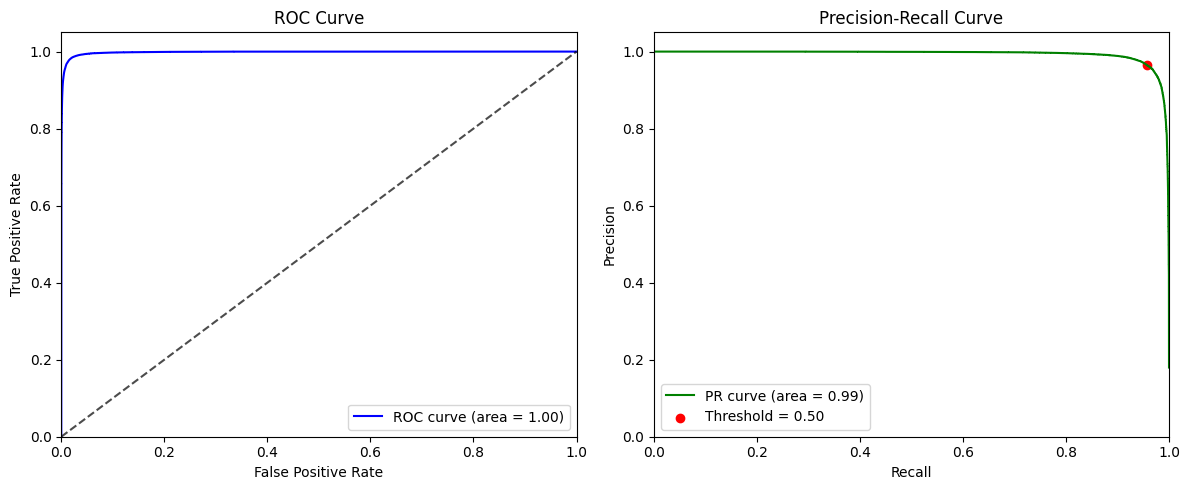

In [33]:
_ = run_model_on_data(model_pt_predict(model), df_test, threshold=0.5)

### Inferencing onnx16 on test

In [49]:
import onnxruntime as ort

def model_onnx_predict(onnx_model_path):
    ort_session = ort.InferenceSession(onnx_model_path)
    def inference(batch_texts):
        inputs = tokenizer(batch_texts, padding='max_length', truncation=True, max_length=128, return_tensors="np")
        ort_inputs = {
            "input_ids": inputs["input_ids"],
            "attention_mask": inputs["attention_mask"]
        }
        logits = ort_session.run(None, ort_inputs)[0]
        return logits
    return inference

In [54]:
%%time
n=20
print(f"running for n={n}")
ort_session = ort.InferenceSession(onnx_16_path)
batch_texts = df_test.loc[10:10+n, "text"].to_list()
inputs = tokenizer(batch_texts, padding='max_length', truncation=True, max_length=128, return_tensors="np")
ort_inputs = {
    "input_ids": inputs["input_ids"],
    "attention_mask": inputs["attention_mask"]
}
logits = ort_session.run(None, ort_inputs)[0]

running for n=20
CPU times: user 10.4 s, sys: 941 ms, total: 11.4 s
Wall time: 16.3 s


In [57]:
print(f"FUCKING HELL THIS WOULD TAKE {((len(df_test)/n) * 16.3) / 60 / 60} hours!")

FUCKING HELL THIS WOULD TAKE 5.621009722222223 hours!


In [78]:
!nvcc --version | sed -n 's/^.*release \([0-9]\+\.[0-9]\+\).*$/\1/p'

12.5


In [79]:
!pip uninstall onnxruntime --quiet
!pip install onnxruntime-gpu --quiet
!export ONNX_PROVIDER=CUDAExecutionProvider
!pip install flatbuffers numpy packaging protobuf sympy
!pip install --pre --index-url https://aiinfra.pkgs.visualstudio.com/PublicPackages/_packaging/ORT-Nightly/pypi/simple/ onnxruntime-gpu

Looking in indexes: https://aiinfra.pkgs.visualstudio.com/PublicPackages/_packaging/ORT-Nightly/pypi/simple/


In [90]:
!python3 -m pip uninstall onnxruntime -y
!python -m pip install onnxruntime-gpu --extra-index-url https://aiinfra.pkgs.visualstudio.com/PublicPackages/_packaging/onnxruntime-cuda-12/pypi/simple/

!python3 -m pip uninstall onnxruntime -y
!python -m pip install onnxruntime-gpu

Looking in indexes: https://pypi.org/simple, https://aiinfra.pkgs.visualstudio.com/PublicPackages/_packaging/onnxruntime-cuda-12/pypi/simple/


In [92]:
%%time
import onnxruntime as ort

n=20
print(f"running for n={n}")
ort_session = ort.InferenceSession(onnx_16_path)
batch_texts = df_test.loc[10:10+n, "text"].to_list()
inputs = tokenizer(batch_texts, padding='max_length', truncation=True, max_length=128, return_tensors="np")
ort_inputs = {
    "input_ids": inputs["input_ids"],
    "attention_mask": inputs["attention_mask"]
}
logits = ort_session.run(None, ort_inputs)[0]

running for n=20
CPU times: user 8.99 s, sys: 1.57 s, total: 10.6 s
Wall time: 27 s


#### Conclusion - к черту onnx, без него нормально жили

Для fp32 float, для fp16 half. Я гений

Processing data...: 100%|██████████| 97/97 [02:58<00:00,  1.84s/it]


Accuracy: 0.99
F1 Score: 0.96
True Positives: 4284
False Positives: 165
True Negatives: 20204
False Negatives: 176
ROC AUC: 0.9983087924651173


NameError: name 'fpr' is not defined

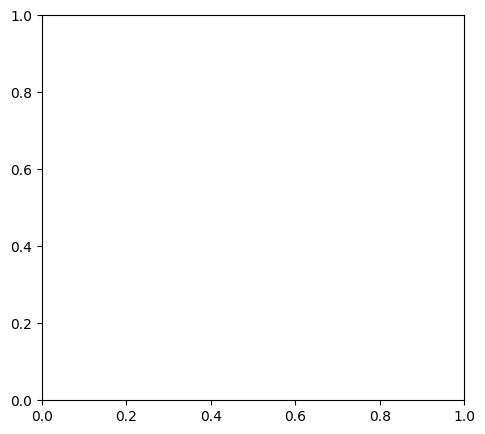

In [12]:
%%time
model.float()
model.eval()

_ = run_model_on_data(model_pt_predict(model), df_test, threshold=0.5)

In [16]:
def model_fp16_predict(model):
    model.half()
    model.eval()
    def inference(batch_texts):
        inputs = tokenizer(batch_texts, padding='max_length', truncation=True, max_length=128, return_tensors="pt")
        inputs = inputs.to(device).half()
        with torch.no_grad():
            outputs = model(**inputs)
            logits = outputs.logits.cpu().numpy()
        return logits
    return inference

Processing data...: 100%|██████████| 97/97 [00:41<00:00,  2.36it/s]

Accuracy: 0.99
F1 Score: 0.96
True Positives: 4284
False Positives: 165
True Negatives: 20204
False Negatives: 176
ROC AUC: 0.9983088530073068


NameError: name 'fpr' is not defined

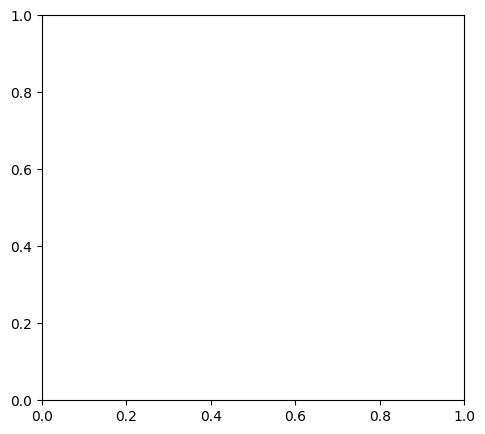

In [13]:
_ = run_model_on_data(model_fp16_predict(model), df_test, threshold=0.5)